In [1]:
from Utils.preprocessing import *
from Utils.pipelineComponents import *
from Utils.preprocessing import *

import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

RANDOM_STATE = 2024

# Webscraping Portion

In [2]:
# Read prof's sample data to view format & data science roles
sample_data_a = pd.read_csv("Data/jobs_in_data.csv")
sample_data_b = pd.read_csv("Data/QF632_Project_2_b.csv")
sample_data_c = pd.read_csv("Data/QF632_Project_2_c.csv")
sample_data_d = pd.read_csv("Data/Glassdoor_Salary_Cleaned_Version.csv")

In [3]:
base_url = "https://h1bdata.info/index.php?em=&job=data+scientist&city=&year=all+years"
roles = ["data scientist", "data analyst", "data storyteller", "data insights", "research scientist", "business data analyst",
        "data analytics", "data engineer", "machine learning", "ml engineer", "ai architect"]

all_df = pd.DataFrame()
for role in roles:
    job = "+".join(role.split(" "))
    url = base_url + "/index.php?em=&job=" + job + "&city=&year=all+years"
    try: 
        dfs_base = pd.read_html(url)
    except: 
        continue
    
    # to include all other variations, add a '&'
    url = base_url + "/index.php?em=&job=" + job + "+&&city=&year=all+years"
    
    try:
        dfs_var = pd.read_html(url)
    except:
        continue
    
    temp_df = pd.concat([dfs_base[0], dfs_var[0]])
    temp_df["TYPE"] = role
    
    all_df = pd.concat([all_df, temp_df])

print(all_df.shape)
all_df.sample(5)

(80866, 8)


,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,Unnamed: 6,TYPE
3015,FORD MOTOR COMPANY,DATA SCIENTIST,80520,"DEARBORN, MI",07/01/2020,12/04/2020,NaN,data scientist
10486,LASAI TECHNOLOGIES LLC,DATA ANALYST,100000,"BELLEVUE, WA",08/12/2022,08/12/2022,NaN,data analyst
8372,META PLATFORMS INC,RESEARCH SCIENTIST,160588,"SEATTLE, WA",07/25/2022,08/01/2022,NaN,research scientist
422,QUANTERIAN LLC,DATA SCIENTIST,125400,"SAN JOSE, CA",05/18/2023,10/01/2023,NaN,data scientist
2978,COMPUTER EVIDENCE SPECIALISTS LLC,DATA ANALYST,61000,"GROVE CITY, OH",03/22/2017,09/21/2017,NaN,data analyst


# Data Analysis

In [4]:
all_df["START DATE"] = pd.to_datetime(all_df["START DATE"], errors='coerce')
all_df["SUBMIT DATE"] = pd.to_datetime(all_df["SUBMIT DATE"], errors='coerce')
all_df = all_df.drop_duplicates()

# Remove all non-numeric "y" values
all_df2 = all_df[pd.to_numeric(all_df['BASE SALARY'], errors='coerce').notnull()].copy()

# all_df2 = all_df.dropna(subset = ["BASE SALARY"]).copy()
all_df2 = all_df2.drop(columns=["Unnamed: 6"]).reset_index(drop=True)
all_df2["YEAR"] = pd.DatetimeIndex(all_df2['START DATE']).year

# To get state, first remove all symbols, then take the last two letters
regex = re.compile('[^a-zA-Z]')
all_df2['STATE'] = all_df2.LOCATION.apply(lambda x:regex.sub('', x)[-2:])
all_df2 = all_df2.rename(columns={"BASE SALARY":"y"})
all_df2["y"] =  pd.to_numeric(all_df2["y"]) / 1000

print(all_df2.shape)
all_df2.sample(5)

(74810, 9)


,EMPLOYER,JOB TITLE,y,LOCATION,SUBMIT DATE,START DATE,TYPE,YEAR,STATE
17892,EQUIFAX INC,DATA SCIENTIST - SPECIALIST,128.378,"ALPHARETTA, GA",2021-12-21,2022-01-03,data scientist,2022,GA
66922,STAPLES INC,DATA ENGINEER II,104.700,"LINCOLNSHIRE, IL",2020-10-07,2021-03-14,data engineer,2021,IL
49013,AMAZONCOM SERVICES LLC,RESEARCH SCIENTIST II,180.274,"SUNNYVALE, CA",2022-07-26,2022-07-31,research scientist,2022,CA
61415,CAREMARK LLC,DATA ENGINEER,125.000,"HARTFORD, CT",2022-11-03,2022-11-10,data engineer,2022,CT
11882,VOLVO CAR TECHNOLOGY USA LLC,DATA SCIENTIST,130.000,"SUNNYVALE, CA",2019-03-18,2019-09-10,data scientist,2019,CA


## Numerical Features

## Categorical features
- Not sure if there is a way to further categorize the data into bigger subgroups (i.e., segregating state to urban and rural areas)

### Job functions

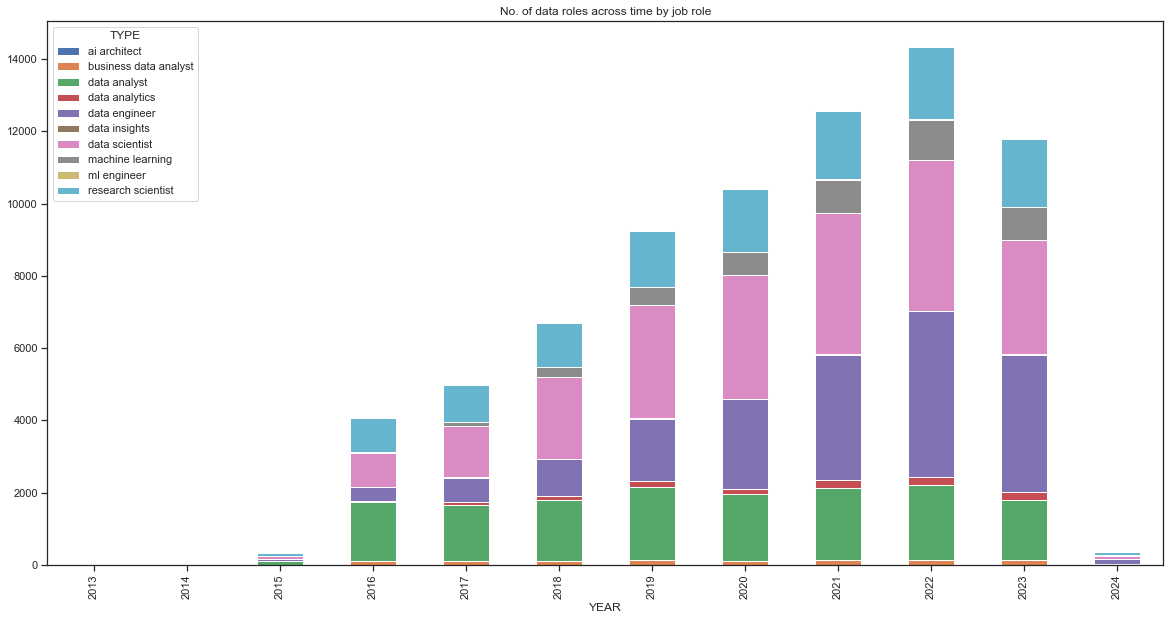

In [5]:
category = "TYPE"

df_plt = all_df2[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="No. of data roles across time by job role")

data scientist        22637
data engineer         18283
data analyst          14573
research scientist    12404
others                 6913
Name: TYPE, dtype: int64


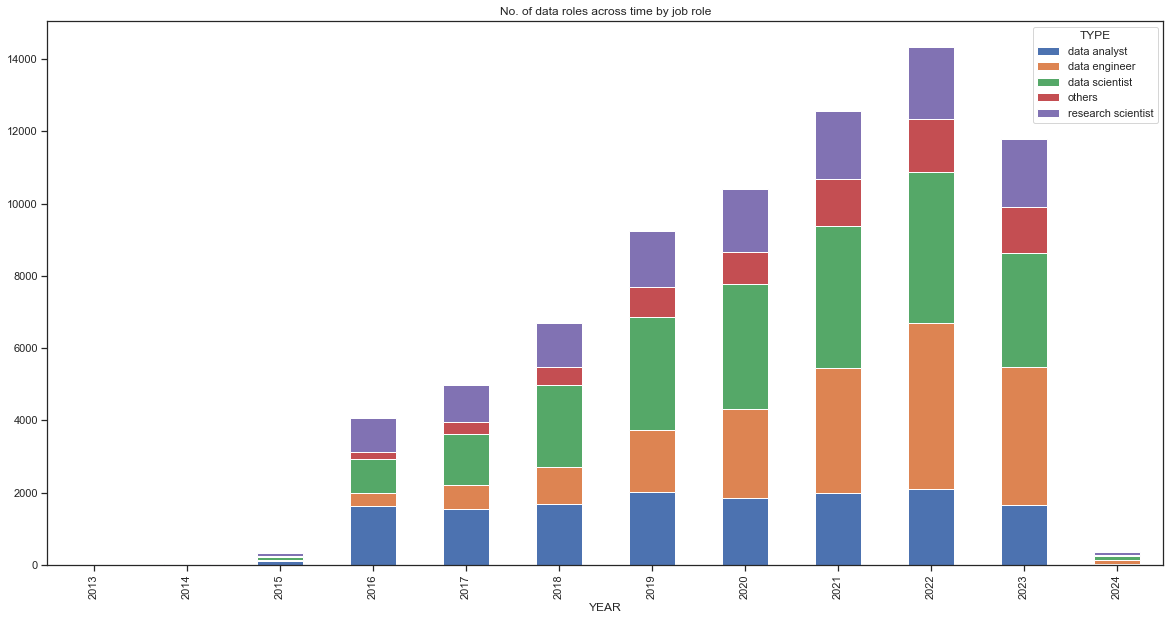

In [6]:
df_type_agg = all_df2.copy()
core_cat = ["research scientist", "data scientist", "data analyst", "data engineer"]
df_type_agg['TYPE'].mask(~df_type_agg["TYPE"].isin(core_cat) ,'others', inplace=True)

df_plt = df_type_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_type_agg["TYPE"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="No. of data roles across time by job role")

Those not of major classes can form 1 class called "others"

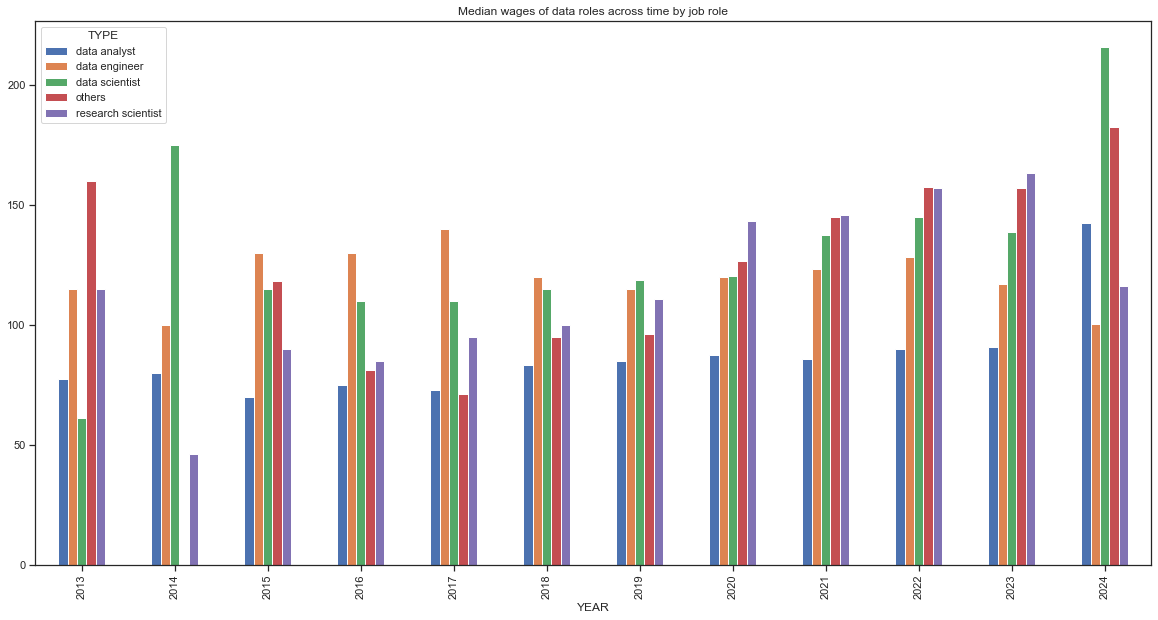

In [7]:
# get median wage of each job role for each year
df_plt = df_type_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by job role")

### State

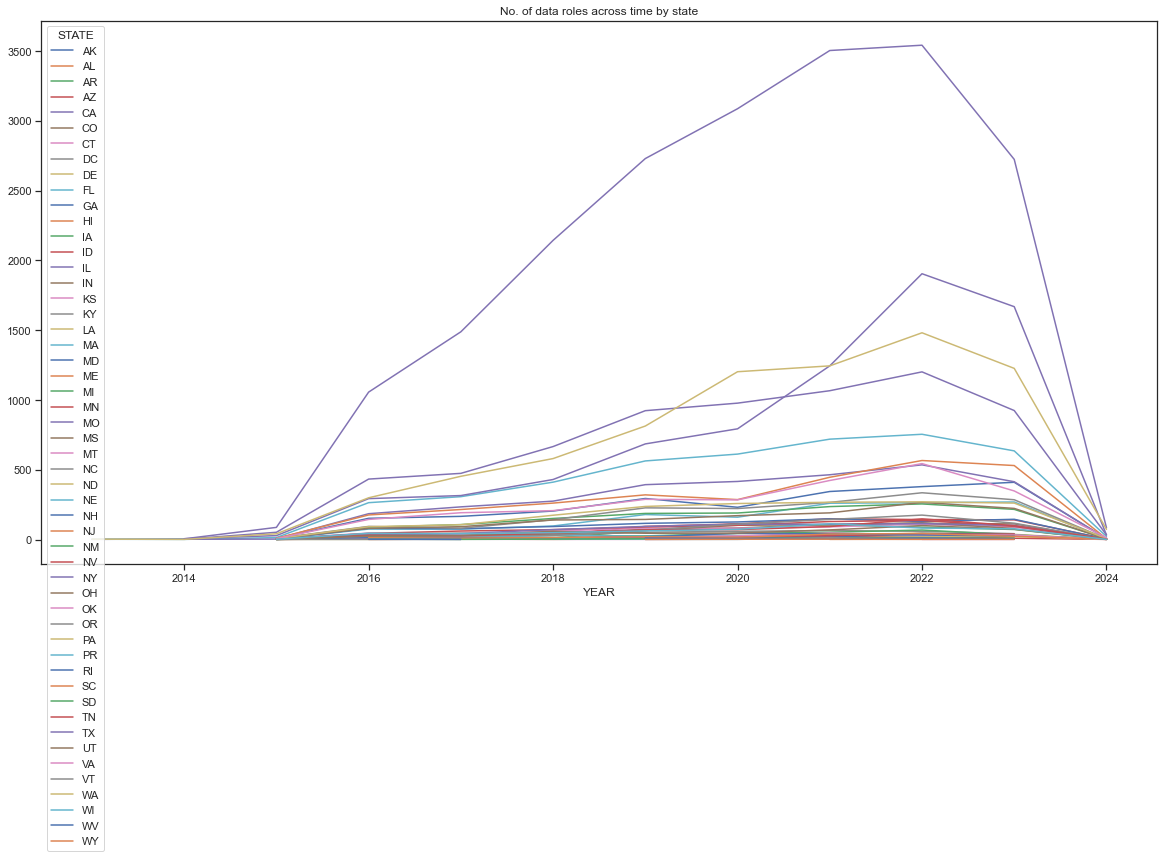

In [8]:
category = "STATE"

df_plt = all_df2[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.line(figsize=(20, 10), title="No. of data roles across time by state")

S    39492
L    35318
Name: STATE_AGG, dtype: int64


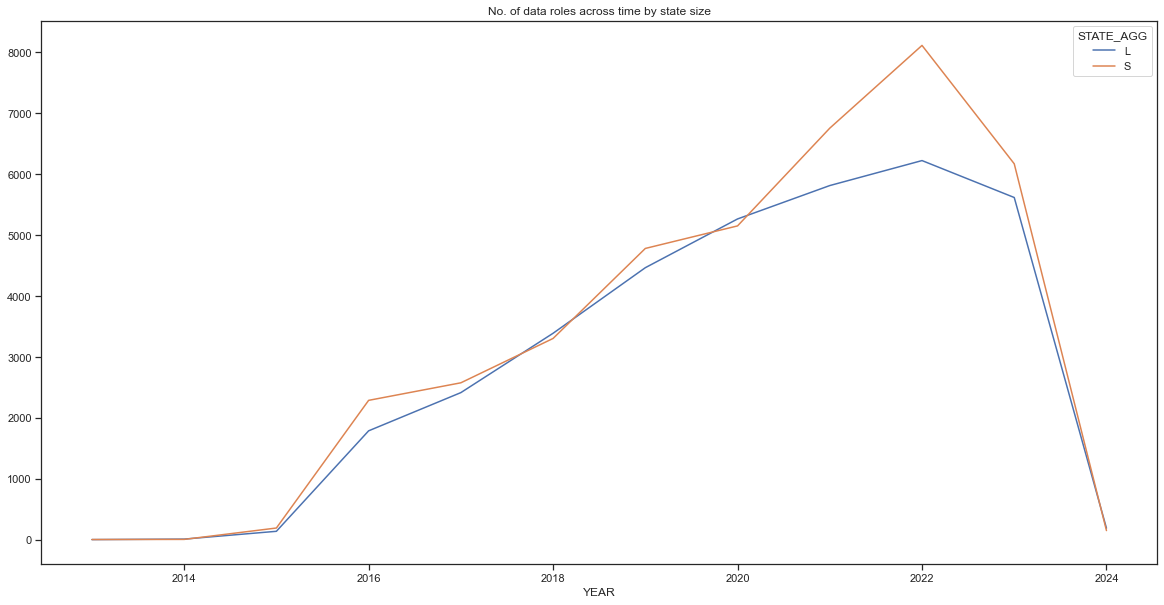

In [9]:
category = "STATE"

years = all_df2["YEAR"].unique()
df_state_agg = all_df2.copy()
df_state_agg["STATE_AGG"] = "L"

# get cumulative no. of hires each year
for year in years:
    df_temp = df_state_agg[df_state_agg["YEAR"] <= year].copy()
    df_temp = df_temp[[category, "y"]].groupby([category], as_index = False).size()
    median = np.quantile(df_temp["size"], 0.95)
    all_S = list(df_temp[df_temp["size"] < median]["STATE"])
    df_state_agg['STATE_AGG'].mask(((df_state_agg["YEAR"] == year) & (df_state_agg["STATE"].isin(all_S))),'S', inplace=True)

category = "STATE_AGG"

df_plt = df_state_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_state_agg["STATE_AGG"].value_counts())
ax = df_plt.plot.line(figsize=(20, 10), title="No. of data roles across time by state size")

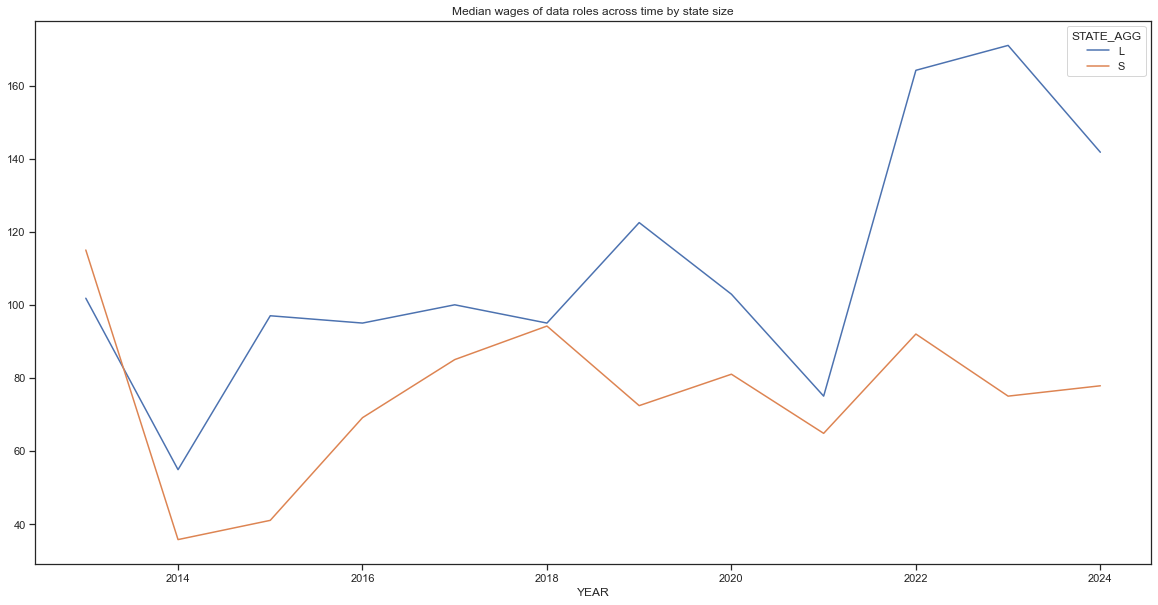

In [10]:
# get median wage of each state size for each year
df_plt = df_state_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.line(figsize=(20, 10), title="Median wages of data roles across time by state size")

### Employer

L    38824
S    35986
Name: EMPLOYER_AGG, dtype: int64


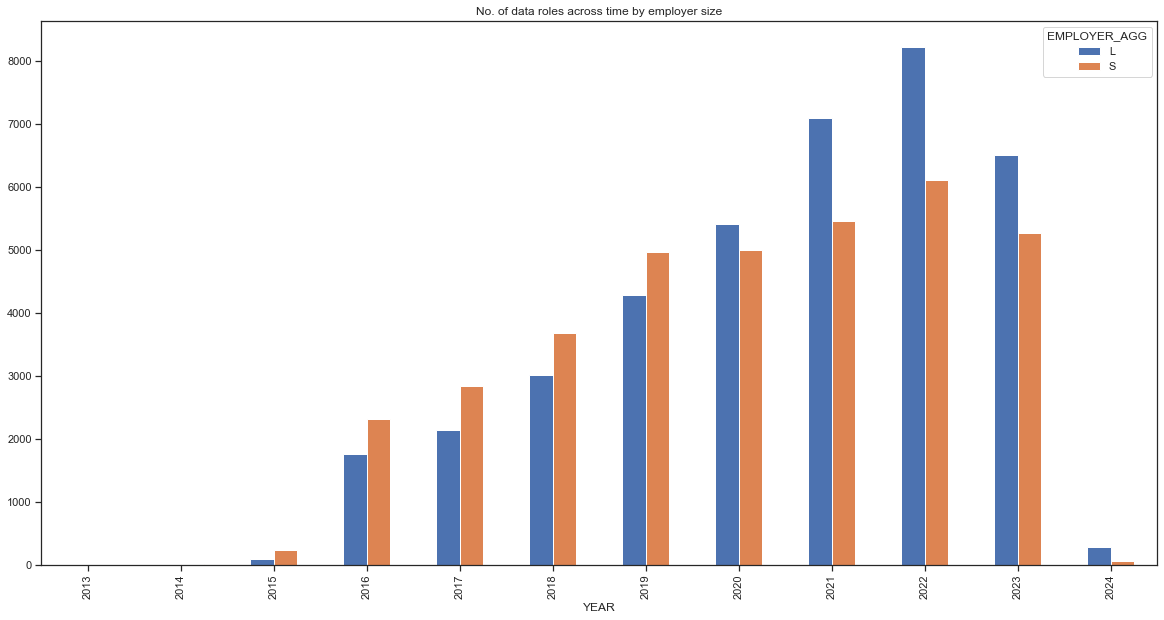

In [11]:
category = "EMPLOYER"

years = all_df2["YEAR"].unique()
df_employer_agg = all_df2.copy()
df_employer_agg["EMPLOYER_AGG"] = "L"

# get cumulative no. of hires each year
for year in years:
    df_temp = df_employer_agg[df_employer_agg["YEAR"] <= year].copy()
    df_temp = df_temp[[category, "y"]].groupby([category], as_index = False).size()
    median = np.quantile(df_temp["size"], 0.95)
    all_S = list(df_temp[df_temp["size"] < median]["EMPLOYER"])
    df_employer_agg['EMPLOYER_AGG'].mask(((df_employer_agg["YEAR"] == year) & (df_employer_agg["EMPLOYER"].isin(all_S))),'S', inplace=True)

category = "EMPLOYER_AGG"

df_plt = df_employer_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_employer_agg["EMPLOYER_AGG"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by employer size")

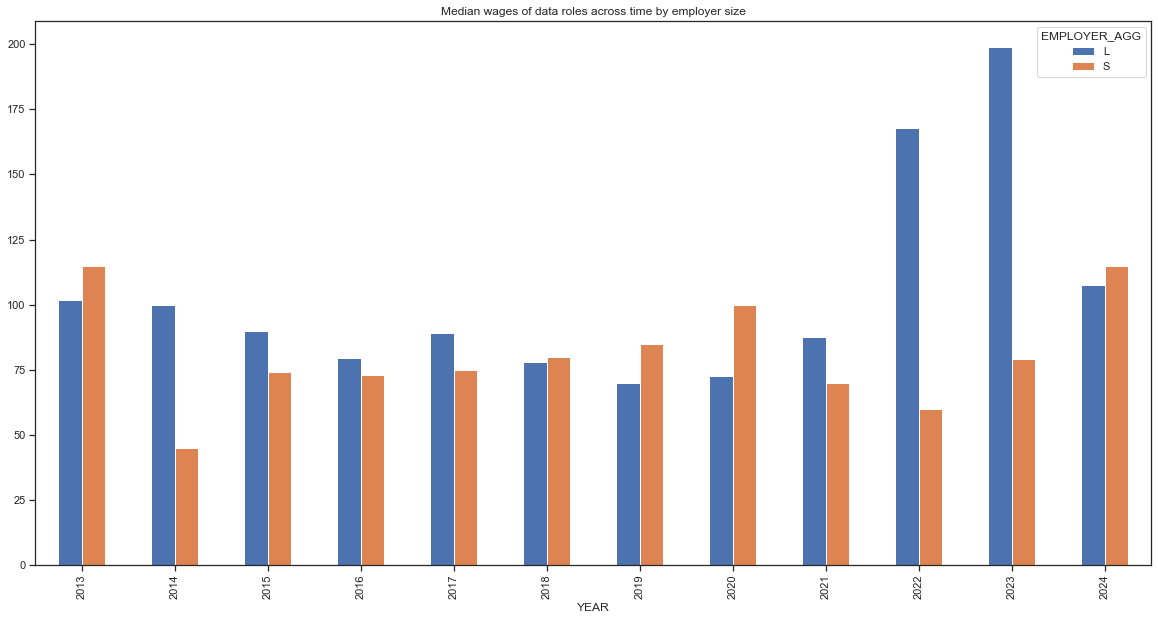

In [12]:
# get median wage of each job role for each year
df_plt = df_employer_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by employer size")

# Encoding

# Regression